<a href="https://colab.research.google.com/github/beau378/projet_scoring_resiliation_contrat_auto/blob/main/notebooks/02_preprocessing_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

if torch.cuda.is_available():
    print(" CUDA est disponible.")
    print("GPU détecté :", torch.cuda.get_device_name(0))
else:
    print(" CUDA n'est pas disponible.")

 CUDA n'est pas disponible.


# 1. Import des données


In [2]:
#Import packages
import pandas as pd

# Import des données
loc_file = r'Resiliation_Contrat_Auto.csv' # Remplacez par votre chemin d'accès aux données
df = pd.read_csv(loc_file,sep=";")
df.head(5)

,CDUSGAUT,IDECON,CD_FML,DTDBUCON,DTEFTMVT,MMJECHPP,MTPAATTC,CDMARVEH,DTOBTPDC,DTPMRMCI,...,DI,SA,IV,RESAU4R,RESMH,RESSA,RESIV,RESDI,CONTRAT,COEFPFLT
0,611.0,205808992,R,14630,14812,121.0,1929.66,PEUGEOT,10273.0,10683.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,ACTIF,0.8500
1,636.0,105939601,C,14701,14701,401.0,4106.44,PEUGEOT,12877.0,11262.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,ACTIF,0.7500
2,603.0,35070,S,4018,14707,407.0,1530.09,MERCEDES,NaN,5935.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,ACTIF,0.8065
3,603.0,700035247,T,6993,14707,407.0,2399.44,RENAULT,2953.0,11596.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,ACTIF,0.9965
4,611.0,500035255,C,7185,14707,1007.0,1342.84,RENAULT,-245.0,9497.0,...,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,ACTIF,0.9716


In [3]:
#Conversion des variables ['CDUSGAUT', 'CD_CSP', 'MOTIFRSL'] en categorielles.
for var in ['CDUSGAUT', 'CD_CSP', 'MMJECHPP']:
    df[var] = df[var].astype('object')


# 2. Traitement des valeurs manquantes de certaines variables numeriques par analyse deductive

## 2.1 valeurs manquantes pour les variables nbre de sinitres

On va ajouter des zeros pour imputer les valeurs manquantes des variables S_i_N et S_i_O, car le taux de valeurs manquantes sont tous eleves, entre 88% et 97% et aussi leurs modalites excluent toutes le chiffre zero. Intuitivement, cela fait du sens que la majorite clients d'une assurance n'enregistrent pas de sinistres.

In [4]:
variables = ['S_0_N', 'S_1_N', 'S_2_N', 'S_3_N', 'S_0_O', 'S_1_O', 'S_2_O', 'S_3_O']
df[variables] = df[variables].fillna(0)

## 2.2 Valeurs manquantes pour les variables de nbres contrats actifs

Dans l'exploration des variables numerique, faite dans la section 2.2, le calcul des valeurs manquantes montre que le nbre de valeurs manquantes pour la variable nbre de contrats actif(NBCTACT) est egal au nbre de valeurs manquantes des variables ('AU4R', 'MH', 'SA', 'IV', 'DI') representant les divers types de contrat d'assurance de l'entreprise .

Verifions a present si les valeurs manquantes sont observees pour les 4 variables de facon simultanee. Une fois cette condition verifiee, on pourra imputer par zero, car les modalite de valeurs de la variable (NBCTACT) ne contenait pas zero, donc on peut supposer que les valeurs manquantes concernent les clients qui n'ont aucun contrats actifs a la fois pour 'AU4R', 'MH', 'SA', 'IV' et 'DI'.

In [5]:
var_principale = 'NBCTACT'
autres_vars = ['AU4R', 'MH', 'SA', 'IV', 'DI']

# Masque des lignes où A est manquant
mask_a_nan = df[var_principale].isna()

# Masque des lignes où les autres variables sont toutes manquantes
mask_autres_nan = df[autres_vars].isna().all(axis=1)

# Vérification
tous_ok = (mask_a_nan == mask_autres_nan).all()

if tous_ok:
    print(" Partout où NBCTACT est manquant, AU4R, MH, SA, IV, DI sont aussi manquants (et inversement).")
else:
    n_incoherents = (mask_a_nan != mask_autres_nan).sum()
    print(f" Il y a {n_incoherents} ligne(s) où la correspondance des NaN n'est pas respectée.")


 Partout où NBCTACT est manquant, AU4R, MH, SA, IV, DI sont aussi manquants (et inversement).


In [6]:
variables = ['NBCTACT','AU4R', 'MH', 'SA', 'IV', 'DI']
df[variables] = df[variables].fillna(0)
#df[variables].isna().sum()

## 2.3 Valeurs manquantes pour les variables de nbres contrats resilies

Les variable de resiliation des divers types de contrats ont chacune 63 741 valeurs manquantes, tandis que la variable qui prend en compte la resiliation de tous les contrat confondu n'a pas de valeurs manquantes et a une modalites qui prend la valeur zero et d'autres valeurs. la premiere intuition serait que la valeur zero de cette variable serait la somme des valeurs manquantes de facon simultanees aux autre variables. verifions l'hypothese.

In [7]:
# Vérifions que toutes les lignes où NBCTRES == 0 ont NaN simultanément pour les variables RESAU4R, RESMH, RESSA, RESIV, RESDI
variables = ['RESAU4R', 'RESMH', 'RESSA', 'RESIV', 'RESDI']
nb_conformes = df[(df['NBCTRES'] == 0) & df[variables].isna().all(axis=1)].shape[0]

print(f"{nb_conformes} ligne(s) où NBCTRES = 0 et toutes les variables d'interet sont manquantes.")

61245 ligne(s) où NBCTRES = 0 et toutes les variables d'interet sont manquantes.


In [8]:
# Remplacement par zero uniquement dans les lignes où NBCTRES == 0
df.loc[df['NBCTRES'] == 0, variables] = df.loc[df['NBCTRES'] == 0, variables].fillna(0)

df[variables].isna().sum()

,0
RESAU4R,2496
RESMH,2496
RESSA,2496
RESIV,2496
RESDI,2496


Il reste donc 2496 valeurs manquantes a traiter pour ls variables RESAU4R, RESMH, RESSA, RESIV, RESDI.

## 2.4 Mise a jour des valeurs manquantes pour les variables numeriques

In [9]:
# Valeurs manquantes _ Variables numériques :
var_num = ['DTOBTPDC', 'MTPAATTC', 'DTPMRMCI', 'ANCCLI', 'RN_VL_VH', 'S_2_N', 'S_1_N', 'S_0_N', 'S_2_O', 'S_1_O', 'S_0_O', 'NIVBM', 'MH', 'DI', 'SA', 'IV', 'RESMH', 'RESSA', 'RESIV', 'RESDI', 'COEFPFLT']
nb_nan = []
for v in var_num:
    nb_nan.append(df[v].isnull().sum())

info_df_num_2 = pd.DataFrame()
info_df_num_2 ["variable"] = var_num
info_df_num_2["NbMissingVal"] = nb_nan
info_df_num_2["%NbMissingVal"] = round(info_df_num_2["NbMissingVal"] / len(df), 2)

info_df_num_2

,variable,NbMissingVal,%NbMissingVal
0,DTOBTPDC,167,0.00
1,MTPAATTC,0,0.00
2,DTPMRMCI,799,0.01
3,ANCCLI,17,0.00
4,RN_VL_VH,141,0.00
5,S_2_N,0,0.00
6,S_1_N,0,0.00
7,S_0_N,0,0.00
8,S_2_O,0,0.00
9,S_1_O,0,0.00


# 3. Prépation des données pour la modélisation

On va qques variables qui ont des valeurs uniques ou presque, qui n'apporte rien au modele predictif. Elles sont identifiantes, pas explicatives. Elles risquent d’introduire du bruit ou des fuites de données dans le modèle. La variable U est constante.

In [10]:
df = df.drop(columns=['IDECON', 'RESAU4R', 'NBCTACT', 'NBCTRES', 'S_3_O', 'S_3_N', 'DTDBUCON', 'DTEFTMVT', 'LBMDLVH', 'MTPAAREF', 'DEPT', 'DT_NAI'])

## 3.1 Regroupement des modalites rare des variables catégorielles

Pour les variables catégorielles avec un nombre de modalités assez faible, nous créerons une variable indicatrice par modalité. Les variables manquantes seront considérées comme une modalité à part entière.

Rq : aucune connaissance par rapport à la variable cible ou par rapport au jeu de données d'apprentissage, nous pouvons donc appliquer cette transformation sans risquer de biasier le modèle.

In [11]:
import pandas as pd

print(f"\nModalités et occurrences :\n")

counts = df['CDUSGAUT'].value_counts()
freqs = df['CDUSGAUT'].value_counts(normalize=True) * 100
modalites = pd.DataFrame({'count': counts, 'pourcentage (%)': freqs})

with pd.option_context('display.max_rows', None):  # pour forcer l'affichage complet
    print(modalites)


Modalités et occurrences :

          count  pourcentage (%)
CDUSGAUT                        
611.0     33065        42.962761
603.0     10895        14.156337
601.0      7068         9.183753
613.0      4497         5.843143
624.0      4143         5.383176
609.0      3162         4.108521
616.0      1686         2.190692
621.0      1686         2.190692
636.0      1406         1.826876
604.0      1225         1.591695
623.0      1125         1.461760
619.0      1097         1.425379
618.0      1046         1.359112
626.0       941         1.222681
628.0       655         0.851069
627.0       623         0.809490
612.0       473         0.614589
668.0       341         0.443076
641.0       232         0.301447
669.0       187         0.242977
617.0       161         0.209194
649.0       142         0.184507
670.0       126         0.163717
639.0       113         0.146826
625.0       113         0.146826
602.0       100         0.129934
659.0        77         0.100049
632.0        7

In [12]:
import pandas as pd

print(f"\nModalités et occurrences :\n")

counts = df['CD_CSP'].value_counts()
freqs = df['CD_CSP'].value_counts(normalize=True) * 100
modalites = pd.DataFrame({'count': counts, 'pourcentage (%)': freqs})

with pd.option_context('display.max_rows', None):  # pour forcer l'affichage complet
    print(modalites)


Modalités et occurrences :

        count  pourcentage (%)
CD_CSP                        
5.0     10704        25.266140
7.0      9023        21.298241
52.0     2558         6.038003
1.0      2347         5.539950
6.0      1899         4.482474
21.0     1585         3.741296
22.0     1377         3.250325
64.0     1019         2.405287
4.0       900         2.124395
54.0      800         1.888351
1201.0    799         1.885991
6238.0    792         1.869468
5411.0    625         1.475274
31.0      479         1.130650
37.0      459         1.083442
69.0      442         1.043314
84.0      426         1.005547
6341.0    386         0.911129
4311.0    326         0.769503
38.0      313         0.738817
1204.0    242         0.571226
55.0      238         0.561784
6311.0    231         0.545261
4611.0    207         0.488611
2156.0    201         0.474448
71.0      191         0.450844
2154.0    187         0.441402
6354.0    171         0.403635
6515.0    153         0.361147
8.0       

In [13]:
#Regroupement des categories rares

# Seuils (en %)
seuils = {
    'CD_FML': 1,
    #'NOTAREFF': 0.2,
    'NOTAREFF': 1,
    'PUI_TRE': 0.5,
    #'PUI_TRE': 5,
    #'CDSITFAM': 0.5,
    'CDSITFAM': 1.5,
    'REGION': 0.5,
    #'CDMARVEH' : 0.01,
    'CDMARVEH' : 0.11,
    #'CDUSGAUT' : 0.01,
    'CDUSGAUT' : 0.12,
    #'CD_CSP' : 0.02,
    'CD_CSP' : 0.19,

}

# Regrouper les modalités rares automatiquement selon le seuil de chaque variable
for var, seuil in seuils.items():
    freqs = df[var].value_counts(normalize=True) * 100
    rares = freqs[freqs < seuil].index
    df[var] = df[var].replace(rares, 'RARE')

#afficher_modalites_occurrences(df)

# 4. Séparation du jeu de données train/ test

In [14]:
target = "CONTRAT"
df[target].value_counts()

,count
CONTRAT,
ACTIF,70528
RESIL,6450


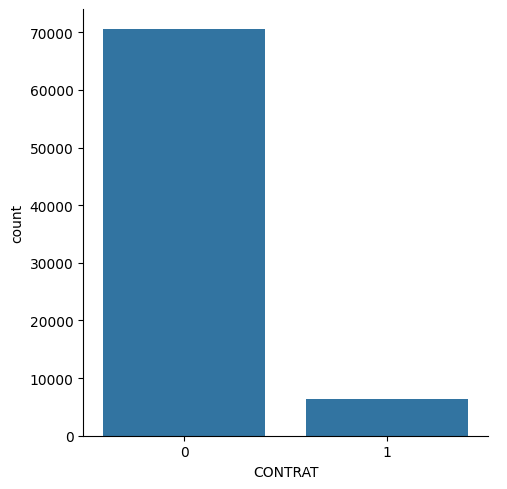

In [15]:
# Encodage de la variable cible
import numpy as np
import seaborn as sns
target = "CONTRAT"
df[target] = np.where(df[target] == 'RESIL', 1, 0)
sns.catplot(x=target,kind="count",data=df)

In [16]:
print("% Variable cible : " + str(df[target].mean()))

% Variable cible : 0.08379017381589544


La variable cible est désiquilibrée : 11 % des contrats sont resilies.
Nous devons respecter cette répartition dans le jeu d'apprentissage et de test.

--> utilisation de la notion d'échantillon stratifié : pour avoir la même répartion dans les 2 jeux de données

# 5. Traitement des valeurs manquantes des variables categorielles

In [17]:
# Pour les variables avec peu de modalité, passage en indicatrice

list_var_cat = ['CDMARVEH', 'CDUSGAUT', 'CDSITFAM', 'CD_FML', 'CD_SEX',
       'CONTRAT', 'NOTAREFF', 'PUI_TRE', 'REGION', 'CD_CSP']

seuil_nb_modalite = 7

#col_to_exclude = ['NO_AFR', 'CD_AGT', 'AUTO4R', 'LBMDLVH', 'CLIACTIF', 'ETAT', 'MOTIFRSL']

list_var_cat_dum = [col for col in list_var_cat if df[col].nunique() <= seuil_nb_modalite]


#list_var_cat_dum.remove('CDMCE')
#list_var_cat_dum.append('NOTAREFF')
#list_var_cat_dum.append('REGION')
#list_var_cat_dum.remove('AUTO4R') #Car constante
#list_var_cat_dum.remove('CDPRGES')
print(list_var_cat_dum)

['CDSITFAM', 'CD_FML', 'CD_SEX', 'CONTRAT', 'NOTAREFF', 'REGION']


In [18]:
list_var_cat_dum.remove("CONTRAT")
#list_var_cat_dum.remove('CD_FML')
list_var_cat_dum.remove("CDSITFAM") #On l'encode a part
list_var_cat_dum.remove("NOTAREFF") #On l'encode a part
print(list_var_cat_dum)

['CD_FML', 'CD_SEX', 'REGION']


In [19]:
# Complete les valeurs valides à 4 chiffres, ignorer les NaNs
df['MMJECHPP_str'] = df['MMJECHPP'].dropna().astype(int).astype(str).str.zfill(4)
df['mois'] = pd.NA
df.loc[df['MMJECHPP'].notna(), 'mois'] = df.loc[df['MMJECHPP'].notna(), 'MMJECHPP_str'].str[:2].astype(int)

# On crée une variable binaire pou MMJECHPP
df['ECH_CON'] = df['mois'].apply(
    lambda x: 'deb_an' if pd.notna(x) and 1 <= x <= 6 else ('fin_an' if pd.notna(x) else pd.NA)
)

df.drop(columns=['MMJECHPP_str', 'mois'], inplace=True)

In [20]:
ech_con_stats = pd.DataFrame({
    "Effectif": df['ECH_CON'].value_counts(),
    "%": (df['ECH_CON'].value_counts(normalize=True) * 100).round(2)
})

ech_con_stats.reset_index(inplace=True)
ech_con_stats.columns = ['Modalité', 'Effectif', '%']
print(ech_con_stats)

  Modalité  Effectif      %
0   deb_an     40603  52.75
1   fin_an     36364  47.25


In [21]:
list_var_cat_dum.append("ECH_CON")
print(list_var_cat_dum)

['CD_FML', 'CD_SEX', 'REGION', 'ECH_CON']


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df, df[target],
    test_size=0.3,
    stratify=df[target],       # pour respecter la distribution de la target
    random_state=42            # pour reproductibilité
)

In [23]:
print(f"Echantillon train: Part y=1 : {y_train.astype(int).mean()}")
print(f"Echantillon test: Part y=1 : {y_test.astype(int).mean()}")

Echantillon train: Part y=1 : 0.08379110682206221
Echantillon test: Part y=1 : 0.08378799688230709


In [24]:

# dummy_na = True : création d'une indicatrice pour les valeurs manquantes
X_train = pd.concat([X_train,pd.get_dummies(X_train[list_var_cat_dum],prefix=list_var_cat_dum,
                                  dummy_na = True,drop_first=True)],axis = 1)

X_test = pd.concat([X_test,pd.get_dummies(X_test[list_var_cat_dum],prefix=list_var_cat_dum,
                                  dummy_na = True,drop_first=True)], axis = 1)

In [25]:
#Encodage CDSITFAM
# Encodage avec 'C' comme référence

dummies_train = pd.get_dummies(X_train["CDSITFAM"], prefix="CDSITFAM")
dummies_train = dummies_train.drop("CDSITFAM_C", axis=1)
X_train = pd.concat([X_train.drop("CDSITFAM", axis=1), dummies_train], axis=1)

dummies_test = pd.get_dummies(X_test["CDSITFAM"], prefix="CDSITFAM")
dummies_test = dummies_test.drop("CDSITFAM_C", axis=1)
X_test = pd.concat([X_test.drop("CDSITFAM", axis=1), dummies_test], axis=1)

In [26]:
#Encodage NOTAREFF
# Encodage avec 'BL050' comme référence

dummies_train = pd.get_dummies(X_train["NOTAREFF"], prefix="NOTAREFF")
dummies_train = dummies_train.drop("NOTAREFF_BL050", axis=1)
X_train = pd.concat([X_train.drop("NOTAREFF", axis=1), dummies_train], axis=1)

dummies_test = pd.get_dummies(X_test["NOTAREFF"], prefix="NOTAREFF")
dummies_test = dummies_test.drop("NOTAREFF_BL050", axis=1)
X_test = pd.concat([X_test.drop("NOTAREFF", axis=1), dummies_test], axis=1)

In [27]:
list_var_car_rest = []
for v in list_var_cat :
    if v!="CONTRAT" and v not in list_var_cat_dum :
        list_var_car_rest.append(v)

#list_var_car_rest.remove('LBMDLVH') #Trop de modalites, risque d'overfitting, variable CDMARVEH est un bon substitut
#list_var_car_rest.remove('MOTIFRSL') #Donne des infos sur la target
#list_var_car_rest.remove('ETAT') #car donne des infos sur la target
#list_var_car_rest.remove("CDMCE") #car donne des infos sur la target
list_var_car_rest.remove("NOTAREFF") #On l'a encodee a part
list_var_car_rest.remove("CDSITFAM") #On l'a encodee a part
#list_var_car_rest.remove("CD_AGT")

print(list_var_car_rest)

['CDMARVEH', 'CDUSGAUT', 'PUI_TRE', 'CD_CSP']


Pour les variables categorielle a plus de 7 modalites, les categories faibles seront regroupes entre eux, si le nbre de categorie depassent 5, leurs modalites seront remplacees par la variable moyenne regularisee de la variable cible par modalites.

In [30]:
for v in list_var_car_rest:

    X_train[v] = X_train[v].fillna("NR")
    X_test[v] = X_test[v].fillna("NR")

    mean_map = X_train.groupby(v)[target].mean()

    sorted_modalities = mean_map.sort_values().index.tolist()

   # Attribue un rang à chaque modalité
    encoding_map = {cat: idx for idx, cat in enumerate(sorted_modalities)}

    X_train[v + "_enc"] = X_train[v].map(encoding_map)
    X_test[v + "_enc"] = X_test[v].map(encoding_map)

    # Modalités jamais vues dans le train (présentes dans le test uniquement)
    X_test[v + "_enc"] = X_test[v + "_enc"].fillna(-1)

In [31]:
X_train.head(5)

,CDUSGAUT,CD_FML,MMJECHPP,MTPAATTC,CDMARVEH,DTOBTPDC,DTPMRMCI,PUI_TRE,RN_VL_VH,S_2_N,...,NOTAREFF_B050,NOTAREFF_B085,NOTAREFF_BL064,NOTAREFF_BL090,NOTAREFF_BL100,NOTAREFF_RARE,CDMARVEH_enc,CDUSGAUT_enc,PUI_TRE_enc,CD_CSP_enc
55831,611.0,D,701.0,3465.49,CITROEN,10101.0,12753.0,X,8.0,0.0,...,False,False,False,True,False,False,10,22,3,36
7266,609.0,C,730.0,957.93,CITROEN,6634.0,2251.0,RARE,2.0,0.0,...,False,False,True,False,False,False,10,24,6,29
13792,624.0,C,1001.0,1309.80,CITROEN,6468.0,10227.0,E,9.0,0.0,...,False,False,False,False,False,False,10,3,4,24
15765,611.0,D,1122.0,1967.52,PEUGEOT,11465.0,11566.0,D,6.0,0.0,...,False,False,True,False,False,False,15,22,8,36
33234,611.0,C,307.0,1510.56,RENAULT,4808.0,10105.0,E,9.0,0.0,...,False,False,False,False,False,False,11,22,4,19


In [32]:
X_test.head()

,CDUSGAUT,CD_FML,MMJECHPP,MTPAATTC,CDMARVEH,DTOBTPDC,DTPMRMCI,PUI_TRE,RN_VL_VH,S_2_N,...,NOTAREFF_B050,NOTAREFF_B085,NOTAREFF_BL064,NOTAREFF_BL090,NOTAREFF_BL100,NOTAREFF_RARE,CDMARVEH_enc,CDUSGAUT_enc,PUI_TRE_enc,CD_CSP_enc
26737,624.0,E,107.0,1123.36,PEUGEOT,-1522.0,8095.0,W,9.0,0.0,...,False,False,False,False,False,False,15,3,7,17
49701,611.0,C,1023.0,1721.04,FIAT,6270.0,11443.0,X,6.0,0.0,...,False,False,False,False,False,False,26,22,3,17
17600,611.0,R,422.0,4145.14,RENAULT,5676.0,14365.0,X,10.0,0.0,...,False,False,True,False,False,False,11,22,3,29
50924,611.0,S,1020.0,1125.98,VOLKSWAGEN,8167.0,9436.0,C,4.0,0.0,...,False,False,True,False,False,False,20,22,11,19
14324,603.0,S,1007.0,1331.74,RARE,1672.0,4749.0,E,7.0,0.0,...,True,False,False,False,False,False,9,9,4,28


# 6. Traitement des valeurs manquantes des variables quantitatives

Présence de variables manquantes : les modèles Pythons ne prennent pas en compte les valeurs manquantes, nous allons créer une indicatrice pour "toper" les valeurs manquantes puis les remplacer la moyenne.

On definit d'abord les jeux de données d'apprentissage et de test, pour remplacer les valeurs manquantes par la moyenne du jeu d'apprentissage !


In [33]:
print(var_num)

['DTOBTPDC', 'MTPAATTC', 'DTPMRMCI', 'ANCCLI', 'RN_VL_VH', 'S_2_N', 'S_1_N', 'S_0_N', 'S_2_O', 'S_1_O', 'S_0_O', 'NIVBM', 'MH', 'DI', 'SA', 'IV', 'RESMH', 'RESSA', 'RESIV', 'RESDI', 'COEFPFLT']


In [34]:
import numpy as np
for v in var_num:
    tmp = X_train[v].isnull().sum() +X_test[v].isnull().sum()
    if tmp > 0 :
        v_missing = v + "_missing"
        X_train[v_missing] = np.where(X_train[v].isnull(),1,0)
        X_test[v_missing] = np.where(X_test[v].isnull(),1,0)
        mean_app = X_train[v].mean()
        X_train[v].fillna(mean_app,inplace = True)
        X_test[v].fillna(mean_app,inplace = True)   ##### --> Valeur de la moyenne de l'apprentissage

/tmp/ipython-input-34-2632042620.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[v].fillna(mean_app,inplace = True)
/tmp/ipython-input-34-2632042620.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [35]:
X_train.head(5)

,CDUSGAUT,CD_FML,MMJECHPP,MTPAATTC,CDMARVEH,DTOBTPDC,DTPMRMCI,PUI_TRE,RN_VL_VH,S_2_N,...,PUI_TRE_enc,CD_CSP_enc,DTOBTPDC_missing,DTPMRMCI_missing,ANCCLI_missing,RN_VL_VH_missing,RESMH_missing,RESSA_missing,RESIV_missing,RESDI_missing
55831,611.0,D,701.0,3465.49,CITROEN,10101.0,12753.0,X,8.0,0.0,...,3,36,0,0,0,0,0,0,0,0
7266,609.0,C,730.0,957.93,CITROEN,6634.0,2251.0,RARE,2.0,0.0,...,6,29,0,0,0,0,0,0,0,0
13792,624.0,C,1001.0,1309.80,CITROEN,6468.0,10227.0,E,9.0,0.0,...,4,24,0,0,0,0,0,0,0,0
15765,611.0,D,1122.0,1967.52,PEUGEOT,11465.0,11566.0,D,6.0,0.0,...,8,36,0,0,0,0,0,0,0,0
33234,611.0,C,307.0,1510.56,RENAULT,4808.0,10105.0,E,9.0,0.0,...,4,19,0,0,0,0,0,0,0,0


## 4.5 Définir les variables d'apprentissages

Ne pas oublier que les variables doivent toutes être quantitatives et sans valeurs manquantes

In [36]:
var_app = []
for v in X_train.columns.tolist():
    if (v!= target) and (not(v in list_var_cat)) and v != 'CDMCE' and v!='CDPRGES' and v!= 'AU4R' and v!= 'RESAU4R' and v != 'CLIACTIF' and v !='MOTIFRSL' and v != 'ETAT' and v != 'MMJECHPP' and v!= 'LBMDLVH' and v != 'CD_AGT' and v!= 'MTPAAREF' and v!= 'COEFCOMM' and v!= 'DT_NAI' and v!= 'NBCTRES' and v!= 'NBCTACT' and v!= 'DTEFTMVT' and v!= 'ECH_CON' and v!= 'CRM' and v not in list_var_car_rest:
        var_app.append(v)
print(var_app)

['MTPAATTC', 'DTOBTPDC', 'DTPMRMCI', 'RN_VL_VH', 'S_2_N', 'S_1_N', 'S_0_N', 'S_2_O', 'S_1_O', 'S_0_O', 'NIVBM', 'ANCCLI', 'MH', 'DI', 'SA', 'IV', 'RESMH', 'RESSA', 'RESIV', 'RESDI', 'COEFPFLT', 'CD_FML_D', 'CD_FML_E', 'CD_FML_R', 'CD_FML_RARE', 'CD_FML_S', 'CD_FML_T', 'CD_FML_nan', 'CD_SEX_M', 'CD_SEX_nan', 'REGION_NE', 'REGION_OU', 'REGION_PA', 'REGION_RA', 'REGION_RARE', 'REGION_SO', 'REGION_nan', 'ECH_CON_fin_an', 'ECH_CON_nan', 'CDSITFAM_D', 'CDSITFAM_M', 'CDSITFAM_RARE', 'NOTAREFF_B050', 'NOTAREFF_B085', 'NOTAREFF_BL064', 'NOTAREFF_BL090', 'NOTAREFF_BL100', 'NOTAREFF_RARE', 'CDMARVEH_enc', 'CDUSGAUT_enc', 'PUI_TRE_enc', 'CD_CSP_enc', 'DTOBTPDC_missing', 'DTPMRMCI_missing', 'ANCCLI_missing', 'RN_VL_VH_missing', 'RESMH_missing', 'RESSA_missing', 'RESIV_missing', 'RESDI_missing']


In [37]:
X_train = X_train[var_app]
X_test = X_test[var_app]

In [39]:
# Sauvegarde locale dans l'environnement Colab
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_frame().to_csv("y_train.csv", index=False)
y_test.to_frame().to_csv("y_test.csv", index=False)

print("Fichiers enregistrés avec succès.")

Fichiers enregistrés avec succès.


In [40]:
print("y_train (5 premières lignes) :")
print(y_train.head())

print("\n-------------------------\n")

print("y_test (5 premières lignes) :")
print(y_test.head())

y_train (5 premières lignes) :
55831    0
7266     0
13792    0
15765    0
33234    0
Name: CONTRAT, dtype: int64

-------------------------

y_test (5 premières lignes) :
26737    0
49701    0
17600    0
50924    1
14324    0
Name: CONTRAT, dtype: int64


La table d'apprentissage et la table de test sont prêtes. Nous pouvons passer à la modélisation